# Presentation Visualizations - India Port Traffic Analysis

This notebook contains all visualizations for the presentation slides, with consistent color schemes and formatting.

In [1]:
# Import required libraries and load data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings('ignore')

# Load the data
df = pd.read_csv('syb-18-chapter_22_shipping_table_22.5.csv')

# Get column names
year_col = df.columns[0]
commodities = [col for col in df.columns[1:] if 'total' not in col.lower()]

# Extract numeric years
years = df[year_col].str.extract(r'(\d{4})')[0].astype(int)

# Define consistent color scheme for all commodities
commodity_colors = {
    'POL (Crude & Product)': '#1f77b4',  # Blue
    'Fertiliser': '#ff7f0e',              # Orange
    'Fertiliser Raw Material': '#2ca02c', # Green
    'Iron Ore': '#d62728',                # Red
    'Coal': '#9467bd',                    # Purple
    'Foodgrains': '#8c564b',              # Brown
    'Others': '#17becf'                   # Cyan
}

print("Data loaded successfully!")
print(f"Years: {years.min()} to {years.max()}")
print(f"Commodities: {commodities}")
df.head()

Data loaded successfully!
Years: 2000 to 2015
Commodities: ['POL (Crude & Product)', 'Fertiliser', 'Fertiliser Raw Material', 'Iron Ore', 'Coal', 'Foodgrains', 'Others']


,Year,POL (Crude & Product),Fertiliser,Fertiliser Raw Material,Iron Ore,Coal,Foodgrains,Others,Total
0,2000-01,108.38,3.03,10.31,40.46,54.52,1.98,62.46,281.13
1,2001-02,103.28,3.49,10.48,45.76,51.25,3.91,69.40,287.58
2,2002-03,109.57,2.88,10.29,50.56,53.04,8.54,78.68,313.55
3,2003-04,122.16,2.86,8.94,58.85,54.90,6.84,90.25,344.80
4,2004-05,126.44,3.85,10.67,76.20,60.65,3.84,102.11,383.76


## Slide 2: The Hook

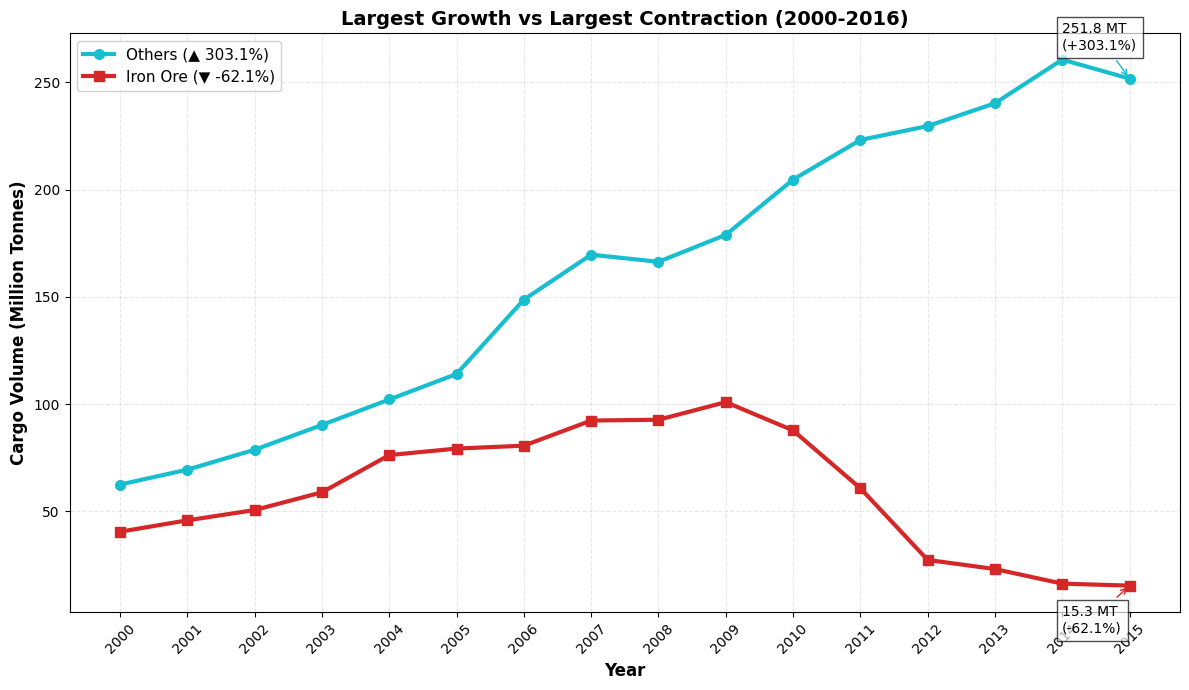

Highest growth: Others -> 303.07%
Highest contraction: Iron Ore -> -62.14%


In [2]:
# Identify commodity with largest growth and largest contraction (excluding totals)
growths = {}
for c in commodities:
    start = df[c].iloc[0]
    end = df[c].iloc[-1]
    if pd.isna(start) or start == 0:
        growths[c] = np.nan
    else:
        growths[c] = (end - start) / start * 100

# Filter out NaNs
valid = {k: v for k, v in growths.items() if not pd.isna(v)}
if not valid:
    raise ValueError("No valid commodity growth values available.")

max_grow_comm = max(valid.items(), key=lambda x: x[1])[0]
max_decline_comm = min(valid.items(), key=lambda x: x[1])[0]
max_grow_pct = valid[max_grow_comm]
max_decline_pct = valid[max_decline_comm]

# Plot both series
plt.figure(figsize=(12, 7))

color_up = commodity_colors.get(max_grow_comm, '#2ca02c')
color_down = commodity_colors.get(max_decline_comm, '#d62728')

plt.plot(years, df[max_grow_comm], marker='o', linewidth=3, markersize=7,
         label=f"{max_grow_comm} (▲ {max_grow_pct:.1f}%)", color=color_up)
plt.plot(years, df[max_decline_comm], marker='s', linewidth=3, markersize=7,
         label=f"{max_decline_comm} (▼ {max_decline_pct:.1f}%)", color=color_down)

# Annotate end values and percent changes
y_end_up = df[max_grow_comm].iloc[-1]
y_end_down = df[max_decline_comm].iloc[-1]
plt.annotate(f"{y_end_up:.1f} MT\n(+{max_grow_pct:.1f}%)", 
             xy=(years.iloc[-1], y_end_up), xytext=(years.iloc[-1] - 1, y_end_up + (plt.ylim()[1]*0.05)),
             arrowprops=dict(arrowstyle='->', color=color_up), fontsize=10, bbox=dict(facecolor='white', alpha=0.7))
plt.annotate(f"{y_end_down:.1f} MT\n({max_decline_pct:.1f}%)", 
             xy=(years.iloc[-1], y_end_down), xytext=(years.iloc[-1] - 1, y_end_down - (plt.ylim()[1]*0.08)),
             arrowprops=dict(arrowstyle='->', color=color_down), fontsize=10, bbox=dict(facecolor='white', alpha=0.7))

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Cargo Volume (Million Tonnes)', fontsize=12, fontweight='bold')
plt.title('Largest Growth vs Largest Contraction (2000-2016)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

# Print summary
print(f"Highest growth: {max_grow_comm} -> {max_grow_pct:.2f}%")
print(f"Highest contraction: {max_decline_comm} -> {max_decline_pct:.2f}%")

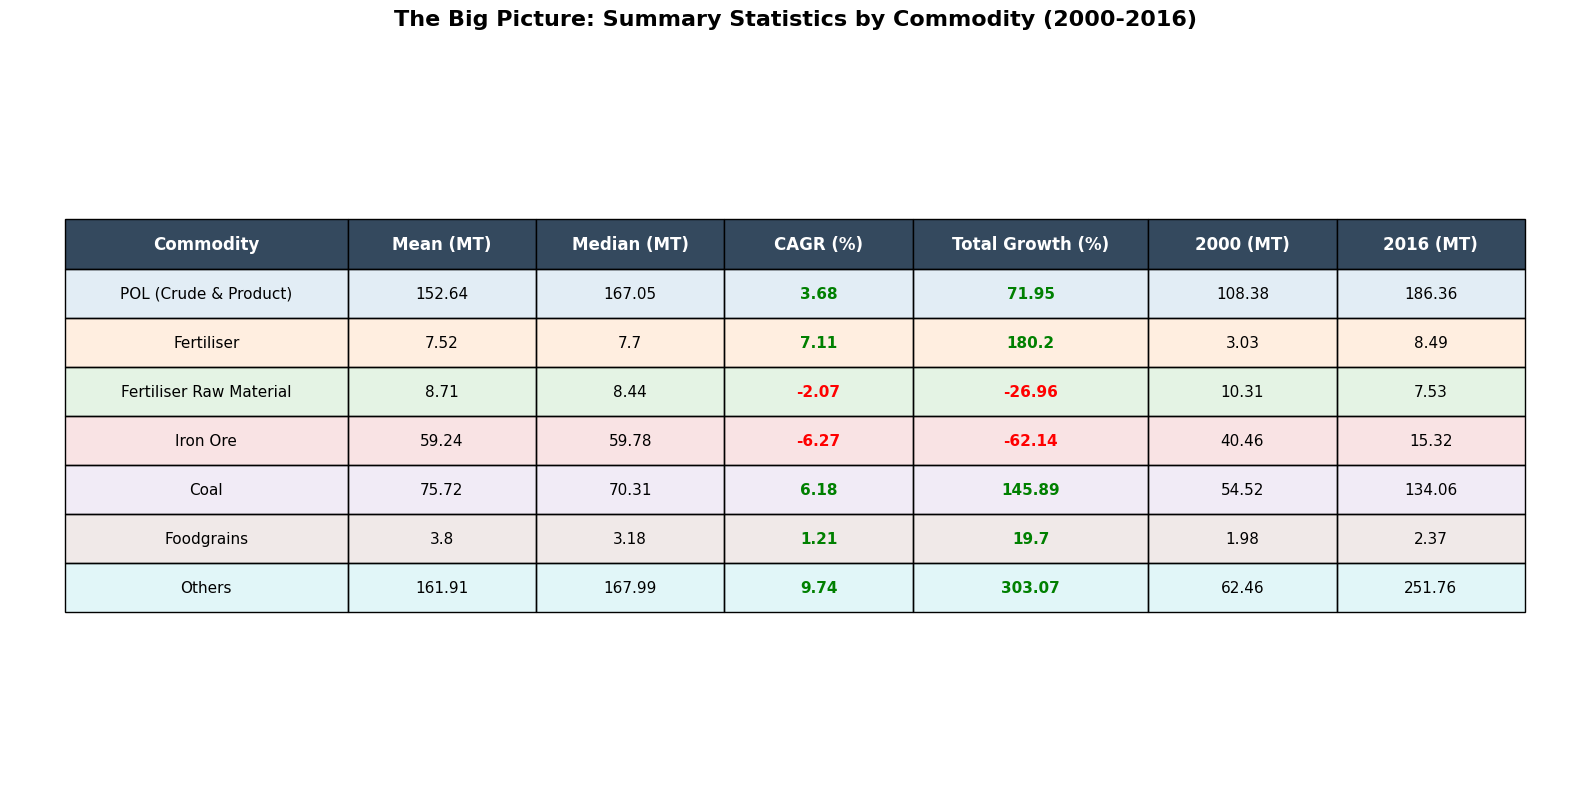


SUMMARY STATISTICS: INDIA PORT TRAFFIC BY COMMODITY (2000-2016)

Commodity                      Mean         Median       CAGR         Total Growth   
------------------------------------------------------------------------------------------
POL (Crude & Product)              152.64 MT     167.05 MT      3.68%         71.95%
Fertiliser                           7.52 MT       7.70 MT      7.11%        180.20%
Fertiliser Raw Material              8.71 MT       8.45 MT     -2.07%        -26.96%
Iron Ore                            59.24 MT      59.78 MT     -6.27%        -62.14%
Coal                                75.72 MT      70.31 MT      6.18%        145.89%
Foodgrains                           3.80 MT       3.18 MT      1.21%         19.70%
Others                             161.91 MT     167.99 MT      9.74%        303.07%


In [5]:
# Calculate summary statistics for each commodity
summary_stats = []

for commodity in commodities:
    data = df[commodity]
    
    # Basic statistics
    mean_val = data.mean()
    median_val = data.median()
    
    # CAGR (Compound Annual Growth Rate)
    start_val = data.iloc[0]
    end_val = data.iloc[-1]
    n_years = len(years) - 1  # 15 years from 2000 to 2015
    
    if start_val > 0:
        cagr = ((end_val / start_val) ** (1 / n_years) - 1) * 100
    else:
        cagr = np.nan
    
    # Total growth percentage
    total_growth = ((end_val - start_val) / start_val * 100) if start_val > 0 else np.nan
    
    summary_stats.append({
        'Commodity': commodity,
        'Mean (MT)': mean_val,
        'Median (MT)': median_val,
        'CAGR (%)': cagr,
        'Total Growth (%)': total_growth,
        '2000 (MT)': start_val,
        '2016 (MT)': end_val
    })

# Create DataFrame
summary_df = pd.DataFrame(summary_stats)

# Create visualization
fig, ax = plt.subplots(figsize=(16, 8))
ax.axis('tight')
ax.axis('off')

# Create table
colors_list = [commodity_colors[commodity] for commodity in commodities]
cell_colors = [[color] * 7 for color in colors_list]
cell_colors = [[c + '20' for c in row] for row in cell_colors]  # Add transparency

table = ax.table(cellText=summary_df.round(2).values,
                colLabels=summary_df.columns,
                cellLoc='center',
                loc='center',
                cellColours=cell_colors,
                colColours=['#34495e'] * len(summary_df.columns),
                colWidths=[0.18, 0.12, 0.12, 0.12, 0.15, 0.12, 0.12])

table.auto_set_font_size(False)
table.set_fontsize(11)
table.scale(1, 2.5)

# Style header
for i in range(len(summary_df.columns)):
    cell = table[(0, i)]
    cell.set_text_props(weight='bold', color='white', fontsize=12)

# Highlight CAGR column with conditional formatting
for i in range(len(summary_df)):
    row = summary_df.iloc[i]
    
    # CAGR column (index 3)
    cagr_cell = table[(i+1, 3)]
    if not pd.isna(row['CAGR (%)']) and row['CAGR (%)'] > 0:
        cagr_cell.set_text_props(weight='bold', color='green')
    else:
        cagr_cell.set_text_props(weight='bold', color='red')
    
    # Total Growth column (index 4)
    growth_cell = table[(i+1, 4)]
    if not pd.isna(row['Total Growth (%)']) and row['Total Growth (%)'] > 0:
        growth_cell.set_text_props(weight='bold', color='green')
    else:
        growth_cell.set_text_props(weight='bold', color='red')

plt.title('The Big Picture: Summary Statistics by Commodity (2000-2016)', 
          fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

# Print detailed summary
print("\n" + "="*90)
print("SUMMARY STATISTICS: INDIA PORT TRAFFIC BY COMMODITY (2000-2016)")
print("="*90)
print(f"\n{'Commodity':<30} {'Mean':<12} {'Median':<12} {'CAGR':<12} {'Total Growth':<15}")
print("-"*90)

for row in summary_stats:
    print(f"{row['Commodity']:<30} {row['Mean (MT)']:>10.2f} MT {row['Median (MT)']:>10.2f} MT "
          f"{row['CAGR (%)']:>9.2f}%  {row['Total Growth (%)']:>12.2f}%")

print("="*90)

## 1. Key Trends: All Commodities (Slide 6)

Multi-line plot showing all commodity trends over time with consistent color scheme.

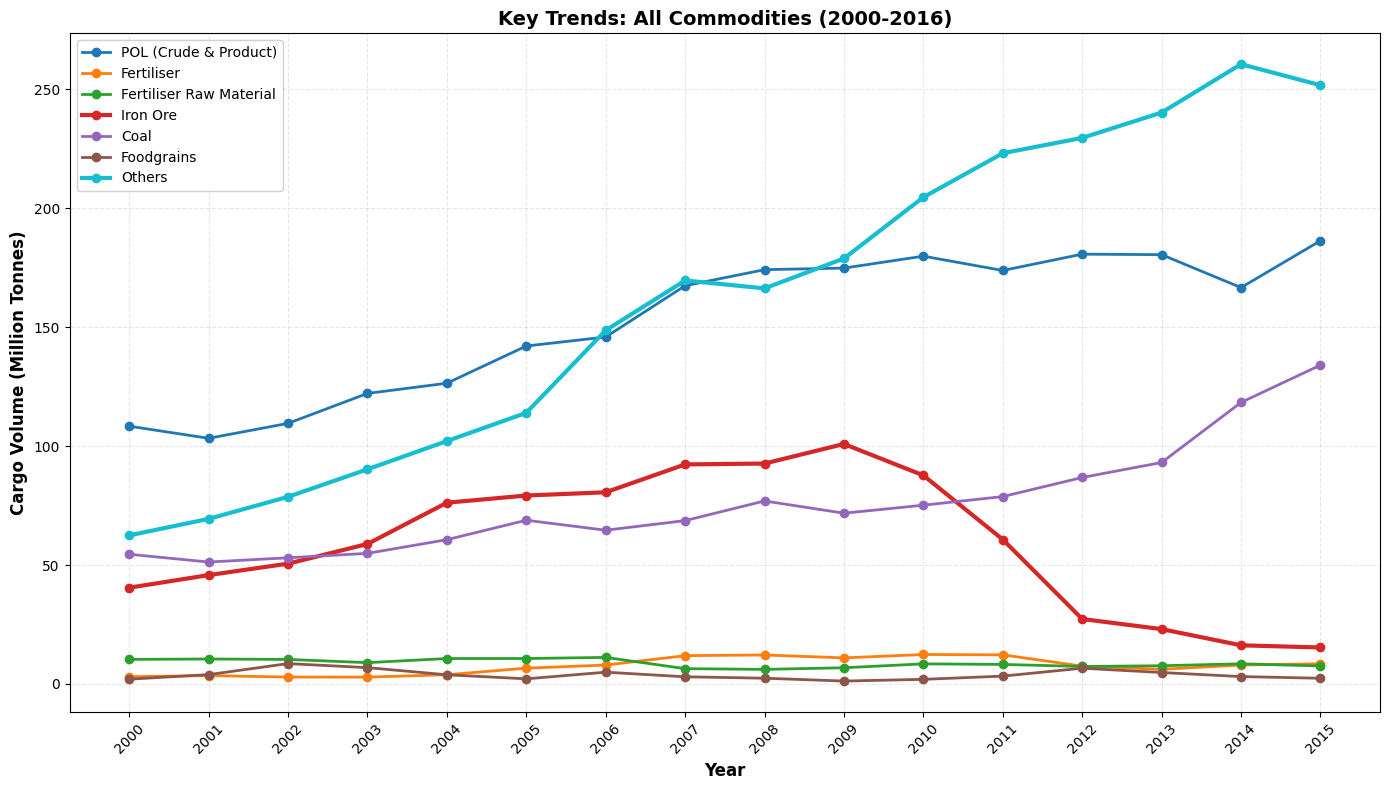

In [8]:
plt.figure(figsize=(14, 8))

for commodity in commodities:
    color = commodity_colors[commodity]
    linewidth = 3 if commodity in ['Iron Ore', 'Others'] else 2
    plt.plot(years, df[commodity], marker='o', label=commodity, 
             color=color, linewidth=linewidth, markersize=6)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Cargo Volume (Million Tonnes)', fontsize=12, fontweight='bold')
plt.title('Key Trends: All Commodities (2000-2016)', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

## 2. A Structural Shift in Trade (Slide 7)

Stacked area chart showing the composition and total volume changes over time.

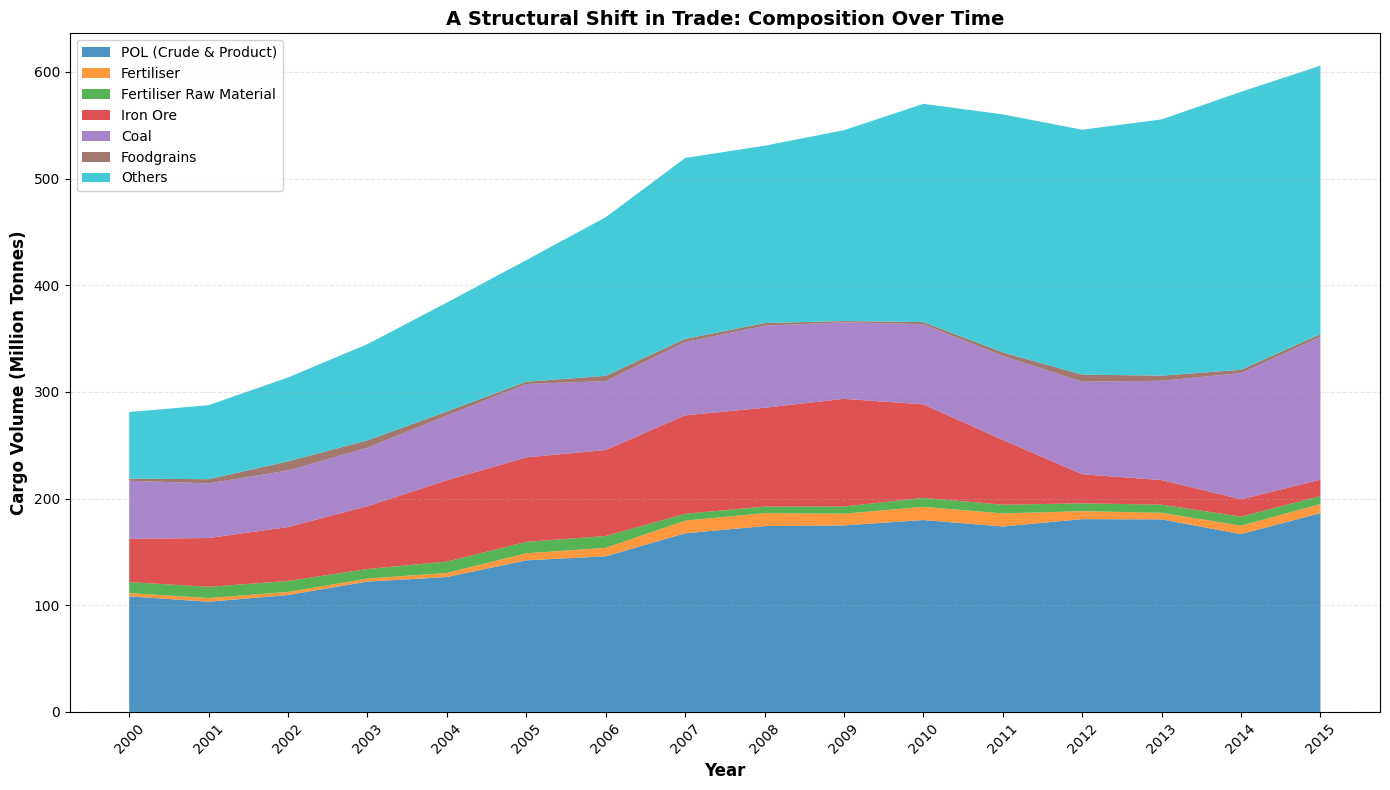

In [9]:
plt.figure(figsize=(14, 8))

# Prepare data for stacked area chart
colors_list = [commodity_colors[commodity] for commodity in commodities]

plt.stackplot(years, *[df[commodity].values for commodity in commodities], 
              labels=commodities, colors=colors_list, alpha=0.8)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Cargo Volume (Million Tonnes)', fontsize=12, fontweight='bold')
plt.title('A Structural Shift in Trade: Composition Over Time', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--', axis='y')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

## 3. How Do Commodities Relate? (Slide 8)

Correlation heatmap showing relationships between commodities.

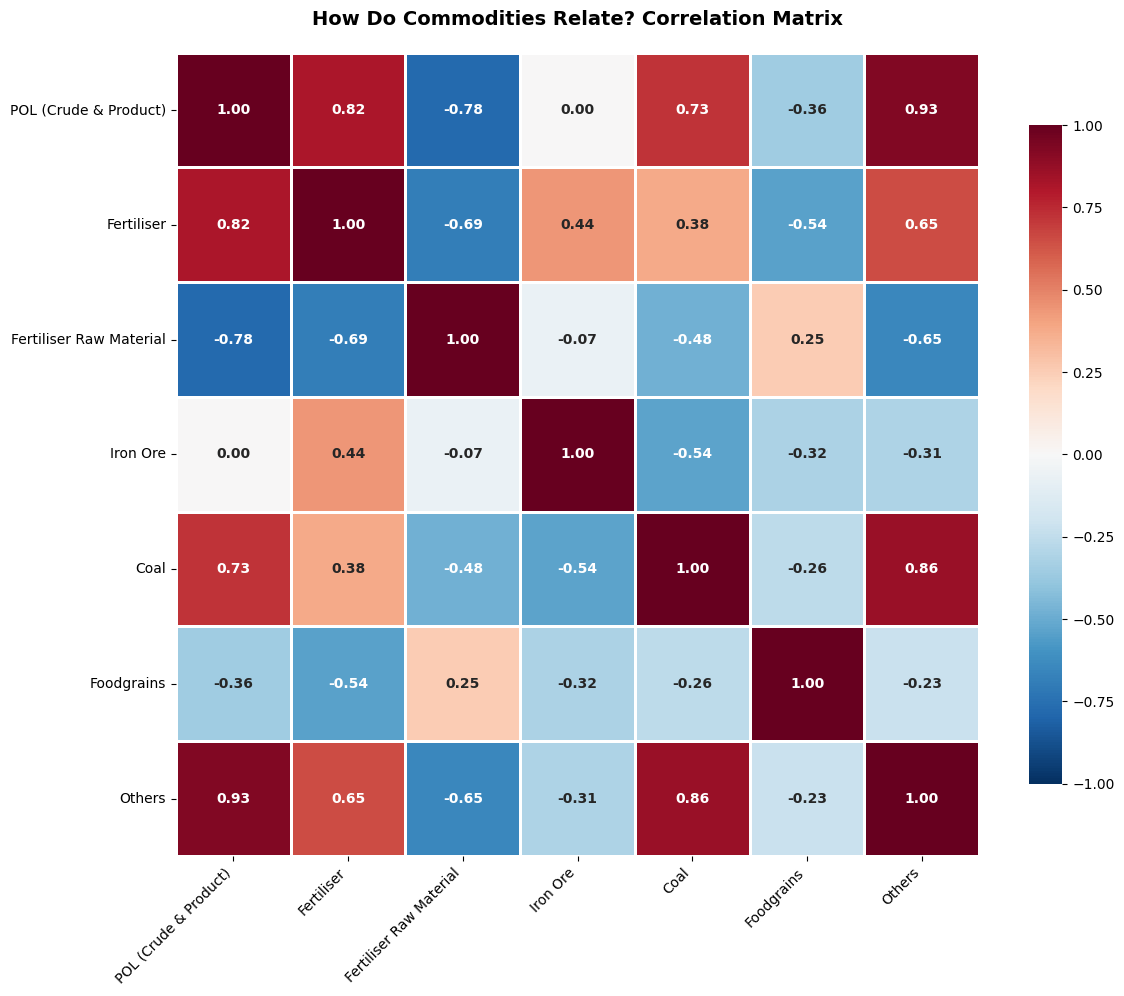

In [10]:
plt.figure(figsize=(12, 10))

# Calculate correlation matrix
corr_matrix = df[commodities].corr()

# Create heatmap with annotations
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8},
            vmin=-1, vmax=1, annot_kws={'fontsize': 10, 'fontweight': 'bold'})

plt.title('How Do Commodities Relate? Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.tight_layout()
plt.show()

## 4. Anchor: Port Traffic vs. GDP (Slide 9)

Dual-axis line chart showing relationship between total cargo growth and India's GDP growth.

**Note:** You'll need to add India's GDP growth data. For now, this cell creates the framework.

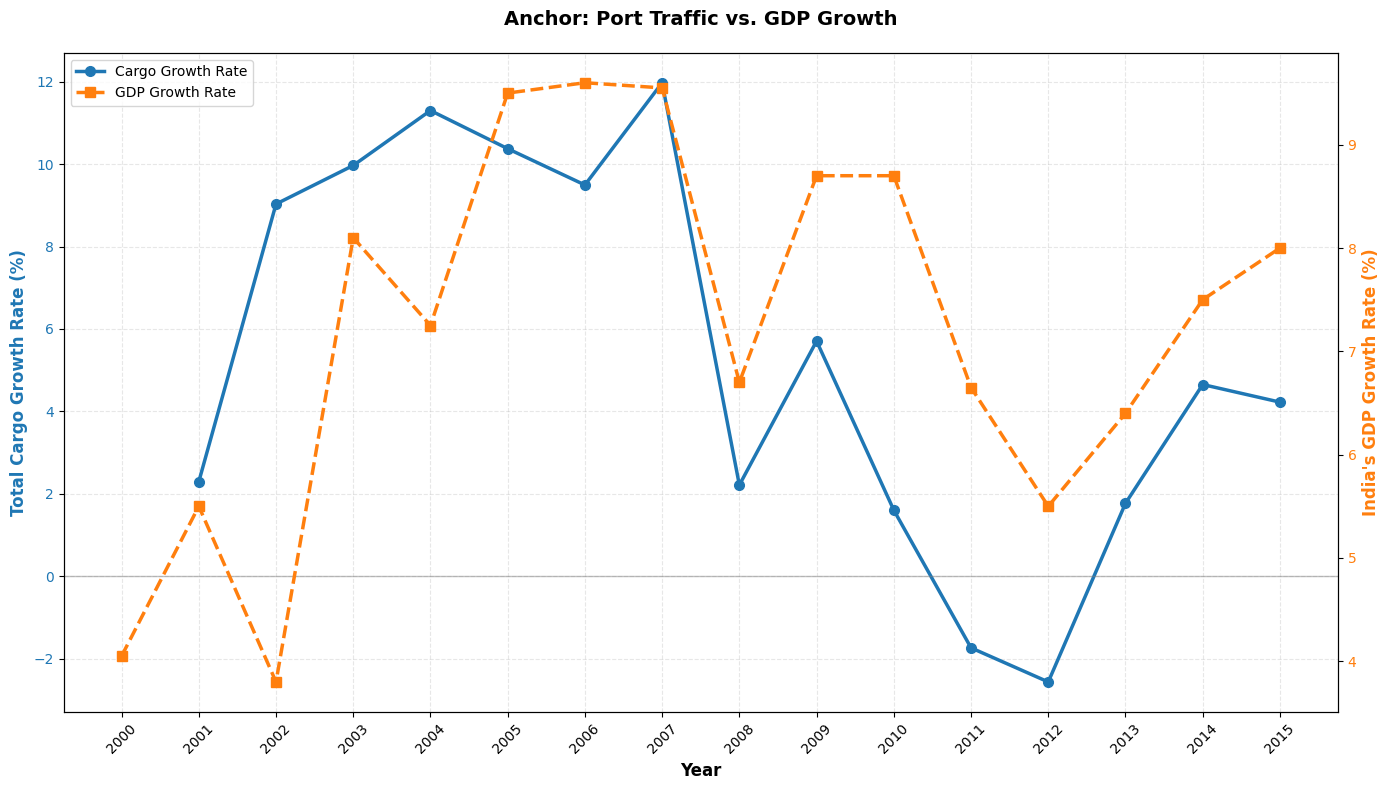

In [7]:
# India's GDP Growth Rate data (2000-2016)
# Source: Government of India Economic Survey / RBI data
gdp_growth = [
    4.05,  # 2000-01 (average of 4.0-4.1)
    5.5,   # 2001-02
    3.8,   # 2002-03
    8.1,   # 2003-04
    7.25,  # 2004-05 (average of 7.0-7.5)
    9.5,   # 2005-06
    9.6,   # 2006-07
    9.55,  # 2007-08 (average of 9.3-9.8)
    6.7,   # 2008-09
    8.7,   # 2009-10 (average of 8.5-8.9)
    8.7,   # 2010-11 (average of 8.5-8.9)
    6.65,  # 2011-12 (average of 6.6-6.7)
    5.5,   # 2012-13
    6.4,   # 2013-14
    7.5,   # 2014-15
    8.0    # 2015-16
]

# Calculate cargo growth rate
total_col = [col for col in df.columns if 'total' in col.lower()][0]
cargo_growth = df[total_col].pct_change() * 100

fig, ax1 = plt.subplots(figsize=(14, 8))

# Plot cargo growth on left axis
color1 = '#1f77b4'
ax1.set_xlabel('Year', fontsize=12, fontweight='bold')
ax1.set_ylabel('Total Cargo Growth Rate (%)', fontsize=12, fontweight='bold', color=color1)
ax1.plot(years, cargo_growth, color=color1, marker='o', linewidth=2.5, 
         markersize=7, label='Cargo Growth Rate')
ax1.tick_params(axis='y', labelcolor=color1)
ax1.grid(True, alpha=0.3, linestyle='--')
ax1.axhline(0, color='gray', linewidth=1, linestyle='-', alpha=0.5)

# Create second y-axis for GDP growth
ax2 = ax1.twinx()
color2 = '#ff7f0e'
ax2.set_ylabel("India's GDP Growth Rate (%)", fontsize=12, fontweight='bold', color=color2)
ax2.plot(years, gdp_growth, color=color2, marker='s', linewidth=2.5, 
         markersize=7, label='GDP Growth Rate', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color2)

# Title and legend
plt.title('Anchor: Port Traffic vs. GDP Growth', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(years)
ax1.set_xticklabels(years, rotation=45)

# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

## 5. The Main Story: An Annotated Timeline (Slide 10)

Multi-line plot with annotations for key events affecting port traffic.

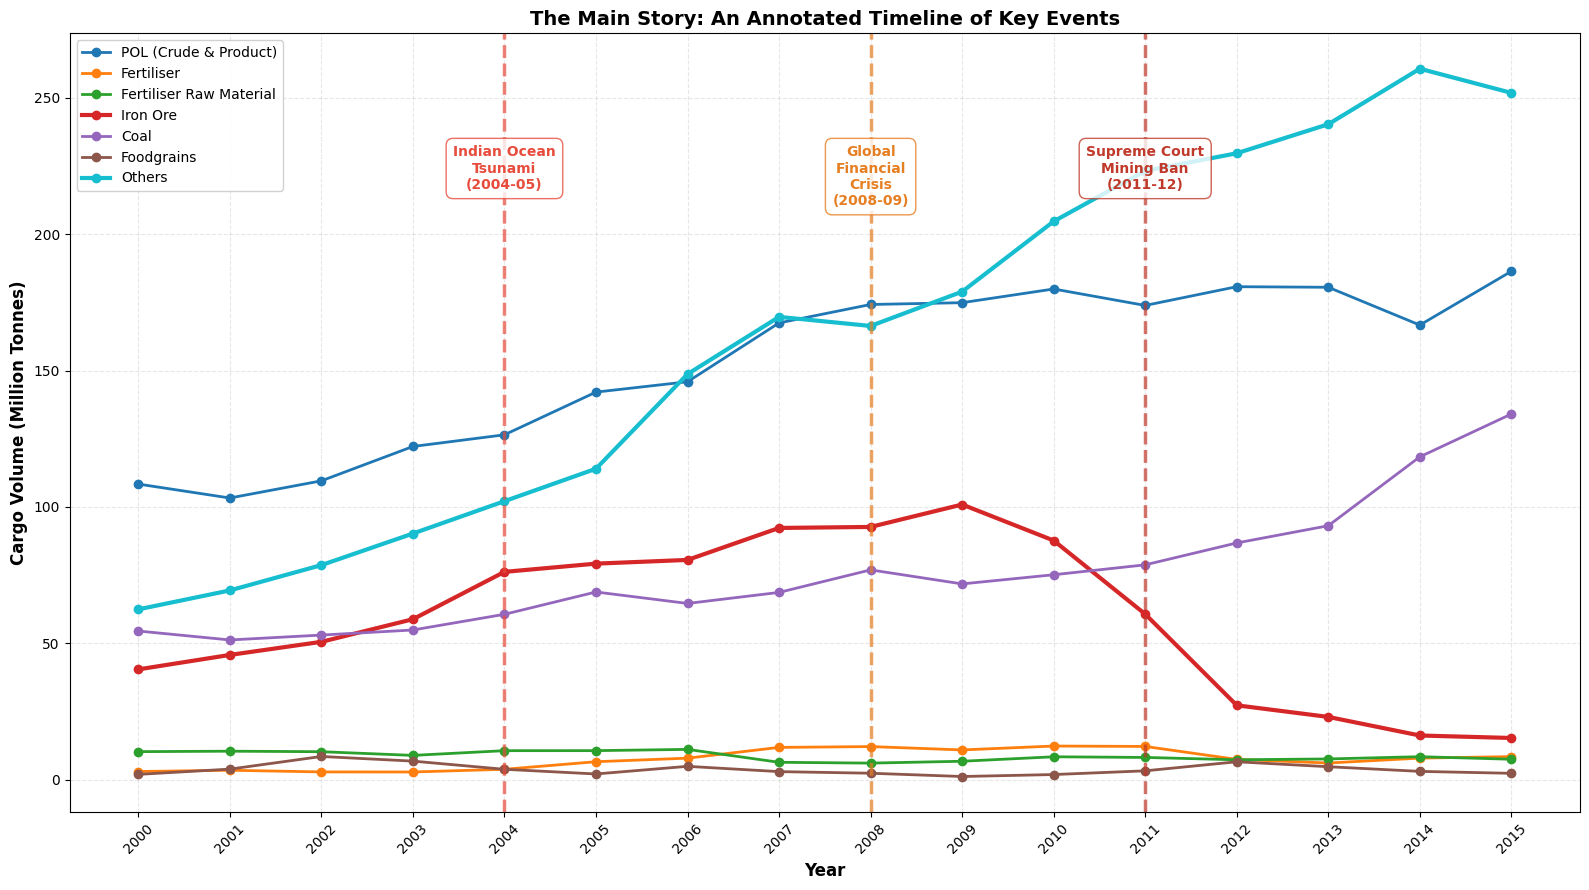

In [12]:
plt.figure(figsize=(16, 9))

# Plot all commodities
for commodity in commodities:
    color = commodity_colors[commodity]
    linewidth = 3 if commodity in ['Iron Ore', 'Others'] else 2
    plt.plot(years, df[commodity], marker='o', label=commodity, 
             color=color, linewidth=linewidth, markersize=6)

# Add vertical lines for key events
event_years = [2004, 2008, 2011]
event_labels = ['Indian Ocean\nTsunami\n(2004-05)', 
                'Global\nFinancial\nCrisis\n(2008-09)', 
                'Supreme Court\nMining Ban\n(2011-12)']
event_colors = ['#e74c3c', '#e67e22', '#c0392b']

for event_year, label, color in zip(event_years, event_labels, event_colors):
    plt.axvline(x=event_year, color=color, linestyle='--', linewidth=2.5, alpha=0.7)
    
    # Add text annotation
    y_position = plt.ylim()[1] * 0.85
    plt.text(event_year, y_position, label, rotation=0, 
             verticalalignment='top', horizontalalignment='center',
             fontsize=10, fontweight='bold', color=color,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                      edgecolor=color, alpha=0.8))

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Cargo Volume (Million Tonnes)', fontsize=12, fontweight='bold')
plt.title('The Main Story: An Annotated Timeline of Key Events', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

## 6. Case Study 1: The 2004 Tsunami (Slide 11)

Zoomed-in view of Foodgrains growth rate from 2003 to 2007, showing tsunami impact.

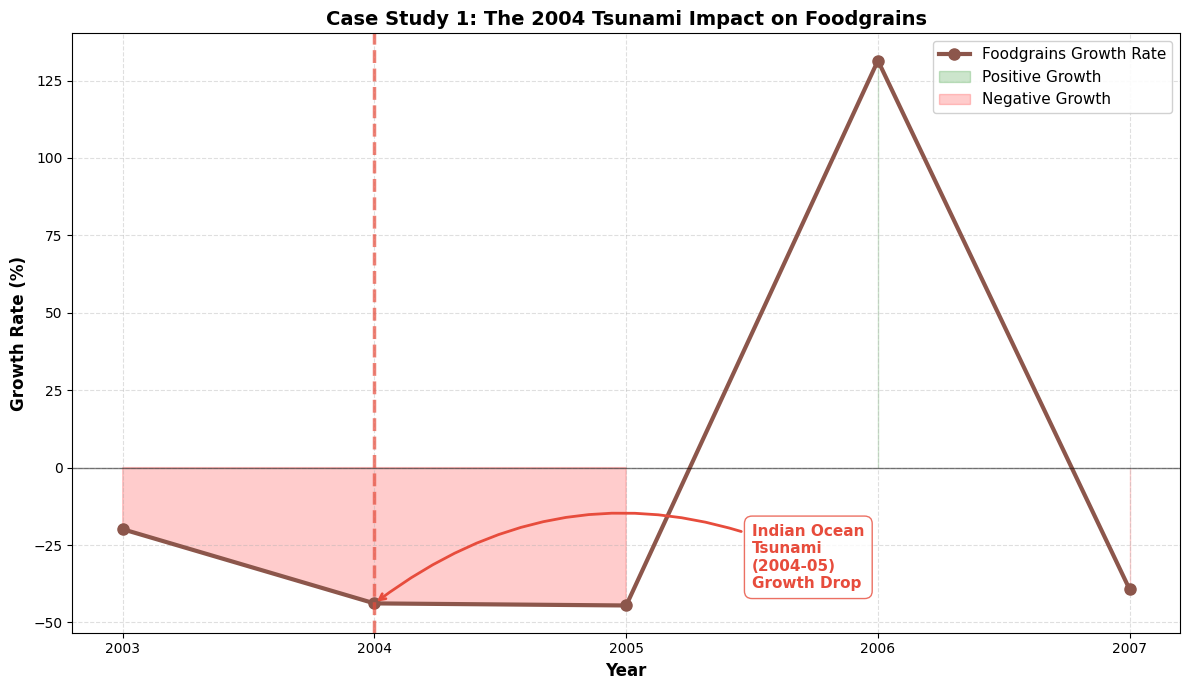


Foodgrains Year-on-Year Growth Rate (2003-2007):
--------------------------------------------------
2003: -19.91%
2004: -43.86%
2005: -44.53%
2006: +131.46%
2007: -39.35%


In [10]:
# Calculate Foodgrains growth rate (year-on-year percentage change)
foodgrains_growth = df['Foodgrains'].pct_change() * 100

# Filter data for 2003-2007
mask = (years >= 2003) & (years <= 2007)
zoom_years = years[mask]
zoom_growth = foodgrains_growth[mask]

plt.figure(figsize=(12, 7))

# Plot Foodgrains growth rate
plt.plot(zoom_years, zoom_growth, marker='o', linewidth=3, 
         markersize=8, label='Foodgrains Growth Rate', color=commodity_colors['Foodgrains'])

# Fill areas for positive and negative growth
plt.fill_between(zoom_years, zoom_growth, 0, where=(zoom_growth >= 0), 
                 color='green', alpha=0.2, label='Positive Growth')
plt.fill_between(zoom_years, zoom_growth, 0, where=(zoom_growth < 0), 
                 color='red', alpha=0.2, label='Negative Growth')

# Add horizontal line at zero
plt.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)

# Add vertical line for tsunami
plt.axvline(x=2004, color='#e74c3c', linestyle='--', linewidth=2.5, alpha=0.7)

# Add annotation with arrow pointing to the growth drop
tsunami_year = 2004
tsunami_idx = list(zoom_years).index(tsunami_year)
growth_at_tsunami = zoom_growth.iloc[tsunami_idx]

arrow_props = dict(arrowstyle='->', connectionstyle='arc3,rad=0.3', 
                   color='#e74c3c', lw=2)
plt.annotate('Indian Ocean\nTsunami\n(2004-05)\nGrowth Drop', 
             xy=(tsunami_year, growth_at_tsunami), 
             xytext=(2005.5, growth_at_tsunami + 5),
             fontsize=11, fontweight='bold', color='#e74c3c',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                      edgecolor='#e74c3c', alpha=0.8),
             arrowprops=arrow_props)

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
plt.title('Case Study 1: The 2004 Tsunami Impact on Foodgrains', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(zoom_years)
plt.tight_layout()
plt.show()

# Print year-on-year growth statistics
print("\nFoodgrains Year-on-Year Growth Rate (2003-2007):")
print("-" * 50)
for year, growth in zip(zoom_years, zoom_growth):
    if pd.notna(growth):
        print(f"{year}: {growth:+6.2f}%")
    else:
        print(f"{year}: N/A (first year)")

## 7. Case Study 2: The 2008 Crisis (Slide 12)

Zoomed-in view showing growth rates of all commodities during the Global Financial Crisis (2006-2011).

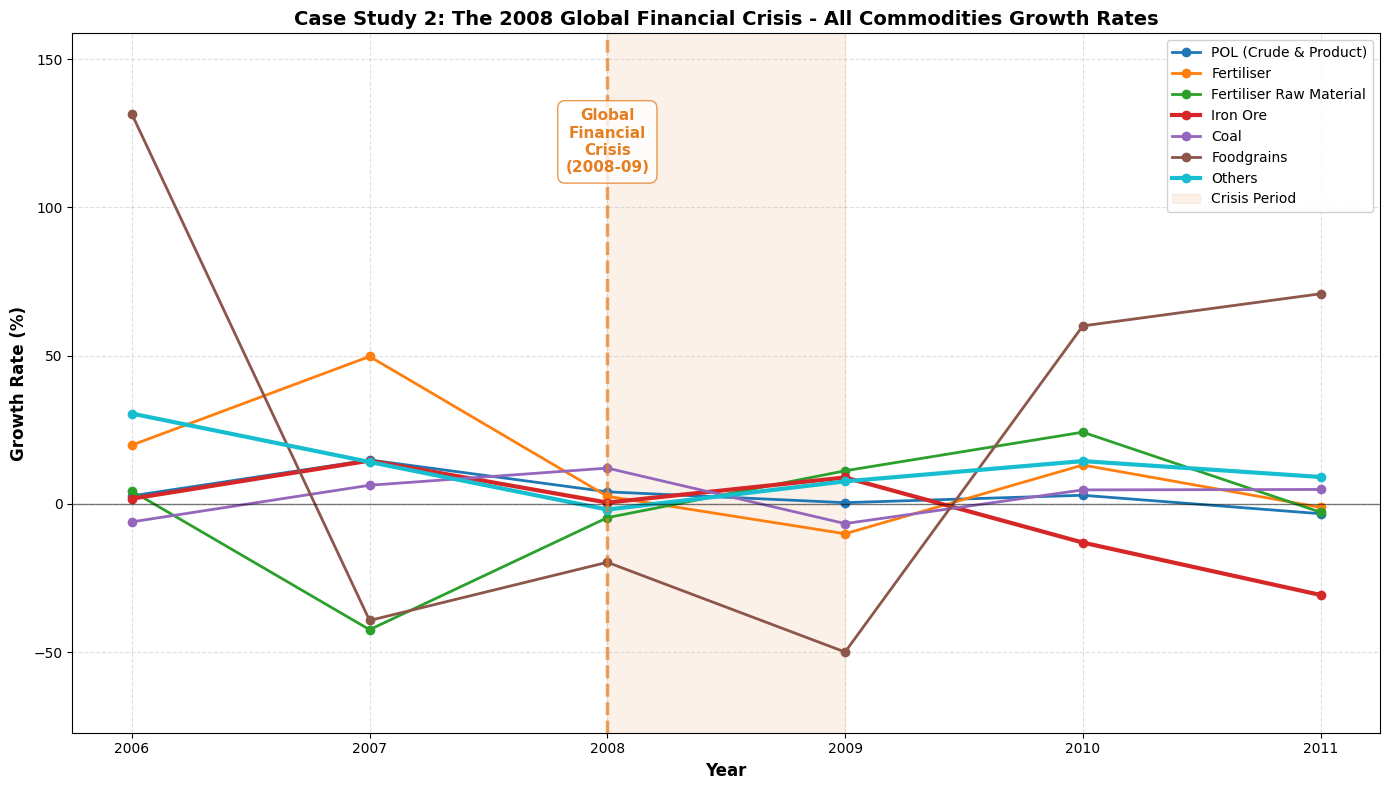


Year-on-Year Growth Rates During Crisis Period:

POL (Crude & Product):
  2007-2008:  +4.04%
  2008-2009:  +0.38%

Fertiliser:
  2007-2008:  +2.53%
  2008-2009: -10.11%

Fertiliser Raw Material:
  2007-2008:  -4.68%
  2008-2009: +11.13%

Iron Ore:
  2007-2008:  +0.40%
  2008-2009:  +8.87%

Coal:
  2007-2008: +12.03%
  2008-2009:  -6.68%

Foodgrains:
  2007-2008: -19.73%
  2008-2009: -50.00%

Others:
  2007-2008:  -1.96%
  2008-2009:  +7.56%



In [17]:
# Calculate growth rates for all commodities
growth_rates = {}
for commodity in commodities:
    growth_rates[commodity] = df[commodity].pct_change() * 100

# Filter data for 2006-2011
mask = (years >= 2006) & (years <= 2011)
zoom_years = years[mask]

plt.figure(figsize=(14, 8))

# Plot growth rates for all commodities
for commodity in commodities:
    color = commodity_colors[commodity]
    linewidth = 3 if commodity in ['Iron Ore', 'Others'] else 2
    plt.plot(zoom_years, growth_rates[commodity][mask], marker='o', 
             linewidth=linewidth, markersize=6, label=commodity, color=color)

# Add horizontal line at zero
plt.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)

# Add vertical line for financial crisis
plt.axvline(x=2008, color='#e67e22', linestyle='--', linewidth=2.5, alpha=0.7)

# Add annotation for financial crisis
y_max = max([growth_rates[c][mask].max() for c in commodities if not pd.isna(growth_rates[c][mask].max())])
plt.text(2008, y_max * 0.85, 'Global\nFinancial\nCrisis\n(2008-09)', 
         ha='center', fontsize=11, fontweight='bold', color='#e67e22',
         bbox=dict(boxstyle='round,pad=0.5', facecolor='white', 
                  edgecolor='#e67e22', alpha=0.8))

# Shade the crisis period
plt.axvspan(2008, 2009, alpha=0.1, color='#e67e22', label='Crisis Period')

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Growth Rate (%)', fontsize=12, fontweight='bold')
plt.title('Case Study 2: The 2008 Global Financial Crisis - All Commodities Growth Rates', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(zoom_years)

# Zoom in on the y-axis to better show the impact
# Set y-axis limits based on the data range with some padding
all_growth_values = [growth_rates[c][mask].dropna() for c in commodities]
y_min = min([vals.min() for vals in all_growth_values if len(vals) > 0])
y_max = max([vals.max() for vals in all_growth_values if len(vals) > 0])
y_padding = (y_max - y_min) * 0.15  # 15% padding
plt.ylim(y_min - y_padding, y_max + y_padding)

plt.tight_layout()
plt.show()

# Print impact statistics for all commodities
print("\nYear-on-Year Growth Rates During Crisis Period:")
print("=" * 80)
crisis_idx = list(zoom_years).index(2008)

for commodity in commodities:
    growth_2007_08 = growth_rates[commodity][mask].iloc[crisis_idx]
    growth_2008_09 = growth_rates[commodity][mask].iloc[crisis_idx + 1]
    
    print(f"\n{commodity}:")
    print(f"  2007-2008: {growth_2007_08:+6.2f}%")
    print(f"  2008-2009: {growth_2008_09:+6.2f}%")
    
print("\n" + "=" * 80)

## 8. Case Study 3: The 2011 Iron Ore Collapse (Slide 13)

Waterfall chart showing year-over-year changes in Iron Ore volume.

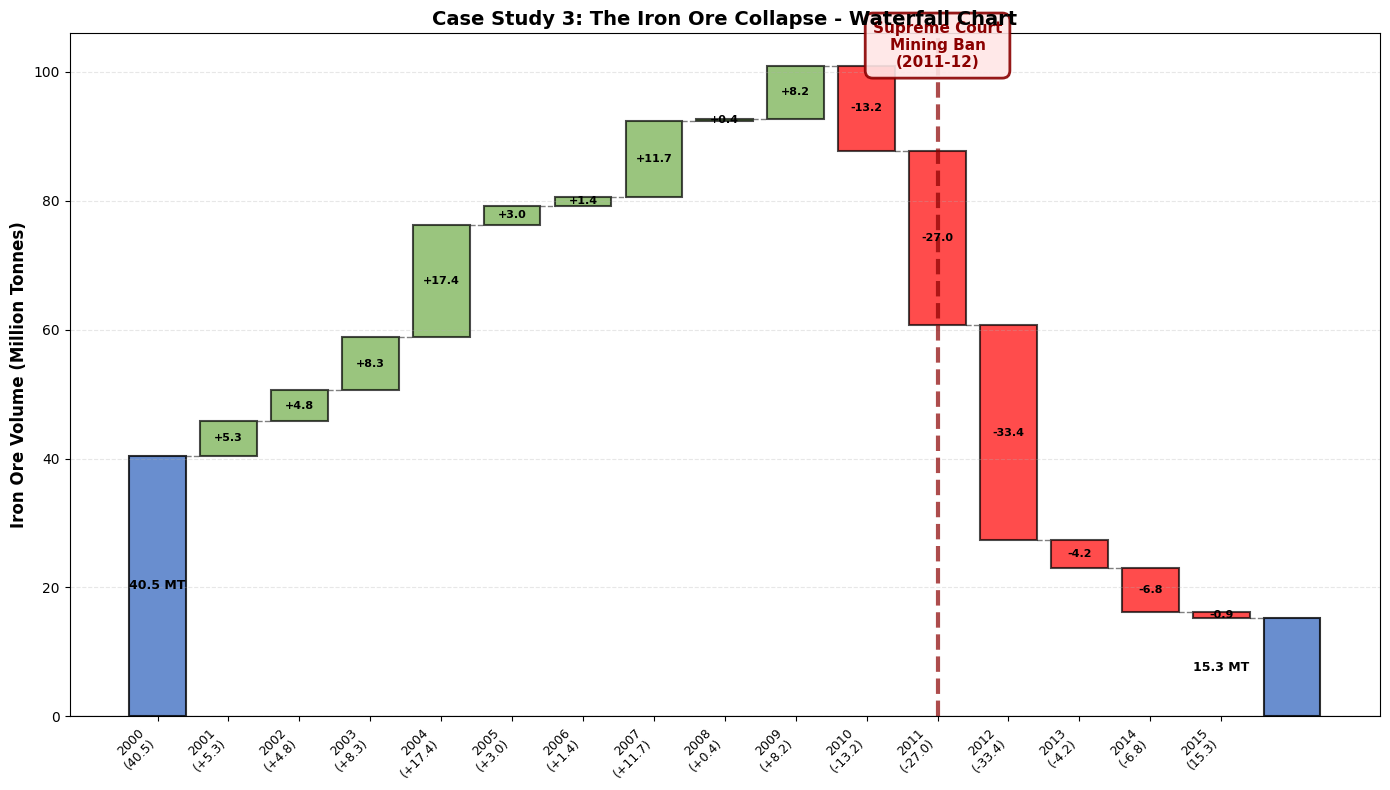


Iron Ore Waterfall Analysis:
Starting value (2000): 40.46 MT
Peak value (2010): 87.69 MT
Ending value (2016): 15.32 MT
Total change (2000-2016): -25.14 MT (-62.14%)
Decline from peak: -82.53%


In [18]:
# Waterfall chart: Year-over-year changes in Iron Ore
iron_ore_data = df['Iron Ore'].values

# Calculate year-over-year changes
yoy_changes = np.diff(iron_ore_data)

# Prepare data for waterfall chart
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate cumulative positions
cumulative = [iron_ore_data[0]]
for change in yoy_changes:
    cumulative.append(cumulative[-1] + change)

# Plot first bar (base year)
ax.bar(0, iron_ore_data[0], color='#4472C4', edgecolor='black', linewidth=1.5, alpha=0.8)

# Plot middle bars (year-over-year changes)
for i in range(len(yoy_changes)):
    if yoy_changes[i] >= 0:
        color = '#70AD47'  # Green for increases
        bottom = cumulative[i]
    else:
        color = '#FF0000'  # Red for decreases
        bottom = cumulative[i+1]
    
    ax.bar(i+1, abs(yoy_changes[i]), bottom=bottom, color=color, 
           alpha=0.7, edgecolor='black', linewidth=1.5)
    
    # Draw connecting line from previous bar
    ax.plot([i+0.4, i+0.6], [cumulative[i], cumulative[i]], 
            'k--', linewidth=1, alpha=0.5)

# Plot last bar (final total)
ax.bar(len(yoy_changes)+1, iron_ore_data[-1], color='#4472C4', 
       edgecolor='black', linewidth=1.5, alpha=0.8)

# Draw final connecting line
ax.plot([len(yoy_changes)+0.4, len(yoy_changes)+0.6], 
        [cumulative[-1], cumulative[-1]], 'k--', linewidth=1, alpha=0.5)

# Add vertical line for mining ban
ban_year_idx = 11  # 2011 is index 11 (2000 is index 0)
ax.axvline(x=ban_year_idx, color='#8b0000', linestyle='--', linewidth=3, alpha=0.7)

# Add annotation for mining ban
ax.text(ban_year_idx, ax.get_ylim()[1] * 0.95, 'Supreme Court\nMining Ban\n(2011-12)', 
        ha='center', fontsize=11, fontweight='bold', color='#8b0000',
        bbox=dict(boxstyle='round,pad=0.5', facecolor='#ffe6e6', 
                 edgecolor='#8b0000', linewidth=2, alpha=0.9))

# Customize chart
year_labels = [f'{year}\n({iron_ore_data[0]:.1f})' if i == 0 
               else f'{year}\n({iron_ore_data[-1]:.1f})' if i == len(years) - 1
               else f'{year}\n({yoy_changes[i-1]:+.1f})'
               for i, year in enumerate(years)]

ax.set_xticks(range(len(years)))
ax.set_xticklabels(year_labels, rotation=45, ha='right', fontsize=9)
ax.set_ylabel('Iron Ore Volume (Million Tonnes)', fontsize=12, fontweight='bold')
ax.set_title('Case Study 3: The Iron Ore Collapse - Waterfall Chart', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y', linestyle='--')
ax.axhline(y=0, color='black', linewidth=0.8)

# Add value labels on bars
ax.text(0, iron_ore_data[0]/2, f'{iron_ore_data[0]:.1f} MT', 
        ha='center', va='center', fontweight='bold', fontsize=9)

for i in range(len(yoy_changes)):
    if yoy_changes[i] >= 0:
        height = cumulative[i] + yoy_changes[i]/2
    else:
        height = cumulative[i+1] + abs(yoy_changes[i])/2
    ax.text(i+1, height, f'{yoy_changes[i]:+.1f}', 
            ha='center', va='center', fontweight='bold', fontsize=8)

ax.text(len(years)-1, iron_ore_data[-1]/2, f'{iron_ore_data[-1]:.1f} MT', 
        ha='center', va='center', fontweight='bold', fontsize=9)

plt.tight_layout()
plt.show()

# Print statistics
peak_year = 2010
peak_idx = 10
peak_value = df['Iron Ore'].iloc[peak_idx]
final_value = df['Iron Ore'].iloc[-1]
decline_pct = ((final_value - peak_value) / peak_value) * 100

print(f"\nIron Ore Waterfall Analysis:")
print(f"Starting value (2000): {iron_ore_data[0]:.2f} MT")
print(f"Peak value ({peak_year}): {peak_value:.2f} MT")
print(f"Ending value (2016): {iron_ore_data[-1]:.2f} MT")
print(f"Total change (2000-2016): {iron_ore_data[-1] - iron_ore_data[0]:.2f} MT ({((iron_ore_data[-1] - iron_ore_data[0]) / iron_ore_data[0] * 100):+.2f}%)")
print(f"Decline from peak: {decline_pct:.2f}%")

## 10. Case Study 5: The 'Rise of Others' (Slide 15)

The dramatic 303% growth story of the "Others" category.

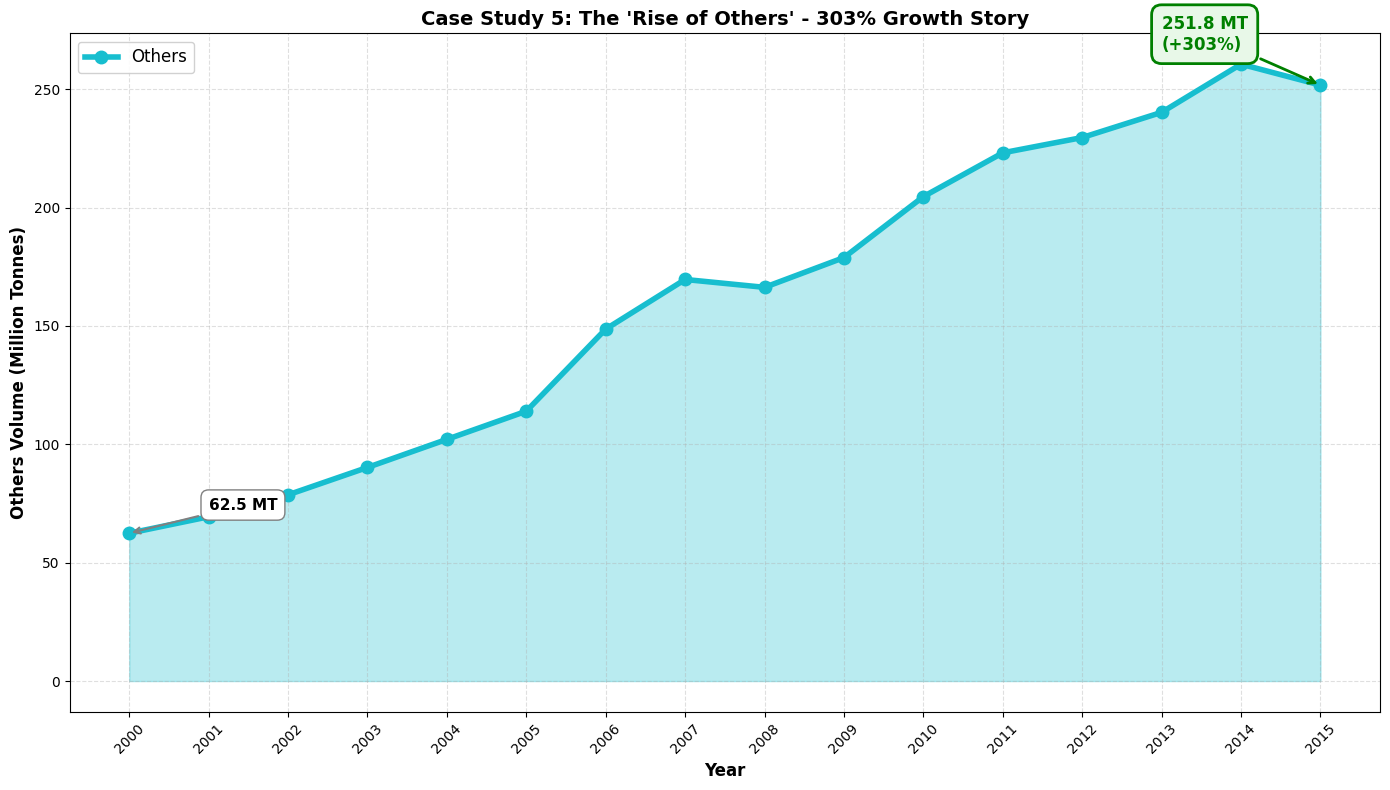

Others in 2000: 62.46 MT
Others in 2016: 251.76 MT
Total Growth: 303.07%


In [17]:
plt.figure(figsize=(14, 8))

# Plot Others with growth color (green/cyan)
plt.plot(years, df['Others'], marker='o', linewidth=4, 
         markersize=9, label='Others', color=commodity_colors['Others'])

# Fill area under the curve to emphasize growth
plt.fill_between(years, df['Others'], alpha=0.3, color=commodity_colors['Others'])

# Add annotations for start and end values
start_val = df['Others'].iloc[0]
end_val = df['Others'].iloc[-1]
growth_pct = ((end_val - start_val) / start_val) * 100

plt.annotate(f'{start_val:.1f} MT', xy=(years.iloc[0], start_val), 
             xytext=(years.iloc[0] + 1, start_val + 10),
             fontsize=11, fontweight='bold',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', edgecolor='gray'),
             arrowprops=dict(arrowstyle='->', color='gray', lw=1.5))

plt.annotate(f'{end_val:.1f} MT\n(+{growth_pct:.0f}%)', xy=(years.iloc[-1], end_val), 
             xytext=(years.iloc[-1] - 2, end_val + 15),
             fontsize=12, fontweight='bold', color='green',
             bbox=dict(boxstyle='round,pad=0.6', facecolor='#e8f8e8', 
                      edgecolor='green', linewidth=2),
             arrowprops=dict(arrowstyle='->', color='green', lw=2))

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Others Volume (Million Tonnes)', fontsize=12, fontweight='bold')
plt.title("Case Study 5: The 'Rise of Others' - 303% Growth Story", fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=12, framealpha=0.9)
plt.grid(True, alpha=0.4, linestyle='--')
plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

print(f"Others in 2000: {start_val:.2f} MT")
print(f"Others in 2016: {end_val:.2f} MT")
print(f"Total Growth: {growth_pct:.2f}%")

HYPOTHESIS TESTING: 2008 GLOBAL FINANCIAL CRISIS IMPACT

H0: Mean cargo traffic before crisis = Mean cargo traffic after crisis
H1: Mean cargo traffic before crisis ≠ Mean cargo traffic after crisis

--------------------------------------------------------------------------------

Commodity                      Mean Before     Mean After      Change %     t-stat     p-value   
----------------------------------------------------------------------------------------------------
POL (Crude & Product)              128.15 MT       177.55 MT     +38.54%     -5.667     0.0001 ***
Fertiliser                           5.32 MT         9.37 MT     +76.23%     -2.685     0.0187 **
Fertiliser Raw Material              9.87 MT         7.77 MT     -21.27%      3.370     0.0050 ***
Iron Ore                            65.49 MT        47.31 MT     -27.76%      1.254     0.2318 
Coal                                59.56 MT        94.01 MT     +57.83%     -3.953     0.0017 ***
Foodgrains                  

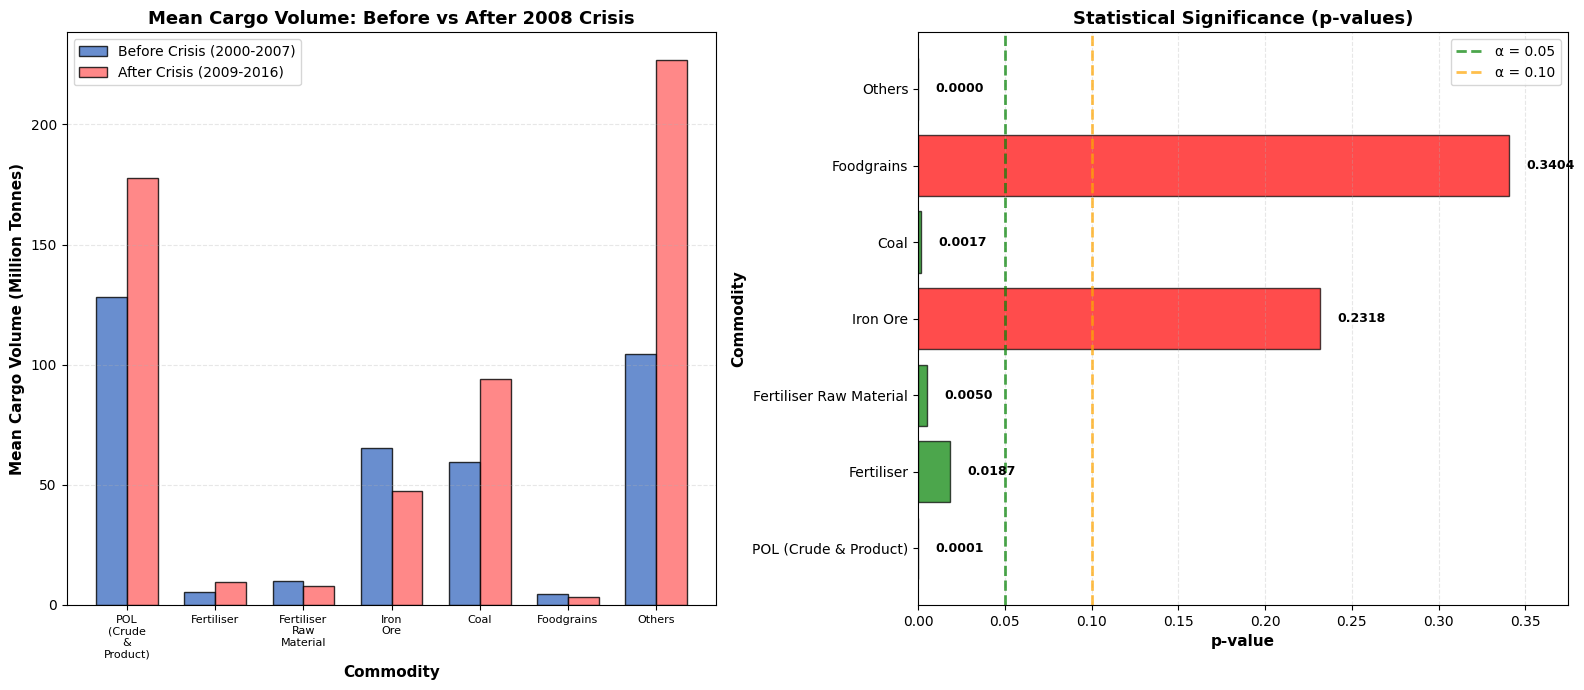


SUMMARY:

Commodities with statistically significant changes (p < 0.05): 5/7

Significant changes:
  - POL (Crude & Product): increased by +38.54% (p = 0.0001)
  - Fertiliser: increased by +76.23% (p = 0.0187)
  - Fertiliser Raw Material: decreased by +21.27% (p = 0.0050)
  - Coal: increased by +57.83% (p = 0.0017)
  - Others: increased by +117.42% (p = 0.0000)



In [19]:
# Hypothesis Testing: 2008 Crisis Impact
from scipy import stats

print("="*80)
print("HYPOTHESIS TESTING: 2008 GLOBAL FINANCIAL CRISIS IMPACT")
print("="*80)
print("\nH0: Mean cargo traffic before crisis = Mean cargo traffic after crisis")
print("H1: Mean cargo traffic before crisis ≠ Mean cargo traffic after crisis")
print("\n" + "-"*80)

# Define crisis year
crisis_year = 2008

# Split data into before and after crisis
before_crisis_mask = years < crisis_year
after_crisis_mask = years > crisis_year

# Perform t-tests for each commodity
results = []

for commodity in commodities:
    before_data = df.loc[before_crisis_mask, commodity].dropna()
    after_data = df.loc[after_crisis_mask, commodity].dropna()
    
    # Calculate statistics
    mean_before = before_data.mean()
    mean_after = after_data.mean()
    std_before = before_data.std()
    std_after = after_data.std()
    
    # Perform two-sample t-test (independent samples)
    t_statistic, p_value = stats.ttest_ind(before_data, after_data)
    
    # Calculate percent change in means
    pct_change = ((mean_after - mean_before) / mean_before) * 100
    
    results.append({
        'Commodity': commodity,
        'Mean Before': mean_before,
        'Std Before': std_before,
        'Mean After': mean_after,
        'Std After': std_after,
        't-statistic': t_statistic,
        'p-value': p_value,
        'Change (%)': pct_change
    })

# Create results DataFrame
results_df = pd.DataFrame(results)

# Print detailed results
print(f"\n{'Commodity':<30} {'Mean Before':<15} {'Mean After':<15} {'Change %':<12} {'t-stat':<10} {'p-value':<10}")
print("-"*100)

for _, row in results_df.iterrows():
    significance = "***" if row['p-value'] < 0.01 else "**" if row['p-value'] < 0.05 else "*" if row['p-value'] < 0.1 else ""
    print(f"{row['Commodity']:<30} {row['Mean Before']:>10.2f} MT   {row['Mean After']:>10.2f} MT   "
          f"{row['Change (%)']:>+8.2f}%   {row['t-statistic']:>8.3f}   {row['p-value']:>8.4f} {significance}")

print("\n" + "-"*100)
print("Significance levels: *** p<0.01, ** p<0.05, * p<0.1")

# Visualize the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 7))

# Left plot: Mean comparison
x_pos = np.arange(len(commodities))
width = 0.35

ax1.bar(x_pos - width/2, results_df['Mean Before'], width, 
        label='Before Crisis (2000-2007)', color='#4472C4', alpha=0.8, edgecolor='black')
ax1.bar(x_pos + width/2, results_df['Mean After'], width, 
        label='After Crisis (2009-2016)', color='#FF6B6B', alpha=0.8, edgecolor='black')

ax1.set_xlabel('Commodity', fontsize=11, fontweight='bold')
ax1.set_ylabel('Mean Cargo Volume (Million Tonnes)', fontsize=11, fontweight='bold')
ax1.set_title('Mean Cargo Volume: Before vs After 2008 Crisis', fontsize=13, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([c.replace(' ', '\n') for c in commodities], fontsize=8, rotation=0)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3, axis='y', linestyle='--')

# Right plot: p-values
colors_pval = ['green' if p < 0.05 else 'orange' if p < 0.1 else 'red' for p in results_df['p-value']]
bars = ax2.barh(commodities, results_df['p-value'], color=colors_pval, alpha=0.7, edgecolor='black')

# Add significance threshold lines
ax2.axvline(x=0.05, color='green', linestyle='--', linewidth=2, alpha=0.7, label='α = 0.05')
ax2.axvline(x=0.10, color='orange', linestyle='--', linewidth=2, alpha=0.7, label='α = 0.10')

ax2.set_xlabel('p-value', fontsize=11, fontweight='bold')
ax2.set_ylabel('Commodity', fontsize=11, fontweight='bold')
ax2.set_title('Statistical Significance (p-values)', fontsize=13, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3, axis='x', linestyle='--')
ax2.set_xlim(0, max(results_df['p-value']) * 1.1)

# Add p-value labels
for i, (commodity, pval) in enumerate(zip(commodities, results_df['p-value'])):
    ax2.text(pval + 0.01, i, f'{pval:.4f}', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary statistics
print(f"\n{'='*80}")
print("SUMMARY:")
print(f"{'='*80}")
significant_changes = results_df[results_df['p-value'] < 0.05]
print(f"\nCommodities with statistically significant changes (p < 0.05): {len(significant_changes)}/{len(commodities)}")
if len(significant_changes) > 0:
    print("\nSignificant changes:")
    for _, row in significant_changes.iterrows():
        direction = "increased" if row['Change (%)'] > 0 else "decreased"
        print(f"  - {row['Commodity']}: {direction} by {abs(row['Change (%)']):+.2f}% (p = {row['p-value']:.4f})")
else:
    print("  No commodities showed statistically significant changes at α = 0.05 level.")
    
print(f"\n{'='*80}")

## 11. Deconstructing the Trend (HP Filter) (Slide 17)

Hodrick-Prescott filter decomposition showing trend and cyclical components.

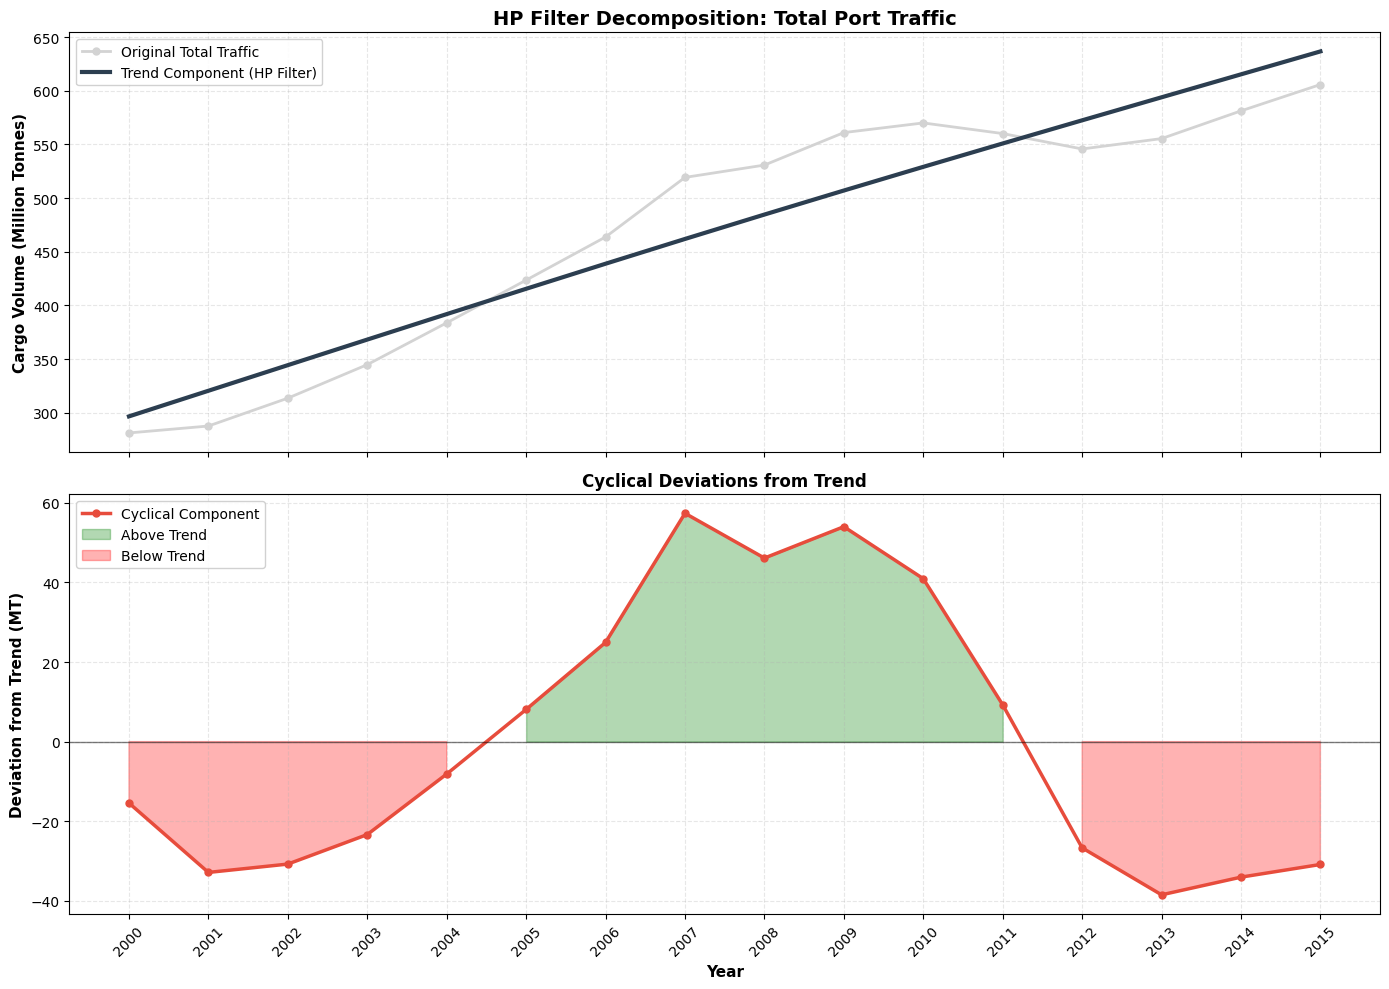

In [18]:
total_col = [col for col in df.columns if 'total' in col.lower()][0]
total_series = df[total_col].dropna()

# Apply HP filter
cycle, trend = hpfilter(total_series, lamb=1600)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Top panel: Original data with trend
ax1.plot(years, total_series, color='lightgray', linewidth=2, 
         label='Original Total Traffic', marker='o', markersize=5)
ax1.plot(years, trend, color='#2c3e50', linewidth=3, 
         label='Trend Component (HP Filter)')
ax1.set_ylabel('Cargo Volume (Million Tonnes)', fontsize=11, fontweight='bold')
ax1.set_title('HP Filter Decomposition: Total Port Traffic', fontsize=14, fontweight='bold')
ax1.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax1.grid(True, alpha=0.3, linestyle='--')

# Bottom panel: Cyclical component
ax2.plot(years, cycle, color='#e74c3c', linewidth=2.5, 
         label='Cyclical Component', marker='o', markersize=5)
ax2.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.5)
ax2.fill_between(years, cycle, 0, where=(cycle >= 0), 
                  color='green', alpha=0.3, label='Above Trend')
ax2.fill_between(years, cycle, 0, where=(cycle < 0), 
                  color='red', alpha=0.3, label='Below Trend')
ax2.set_xlabel('Year', fontsize=11, fontweight='bold')
ax2.set_ylabel('Deviation from Trend (MT)', fontsize=11, fontweight='bold')
ax2.set_title('Cyclical Deviations from Trend', fontsize=12, fontweight='bold')
ax2.legend(loc='upper left', fontsize=10, framealpha=0.9)
ax2.grid(True, alpha=0.3, linestyle='--')

plt.xticks(years, rotation=45)
plt.tight_layout()
plt.show()

## 12. Forecasting: The ARIMA Model (Slide 18)

ARIMA forecast with confidence intervals for future predictions.

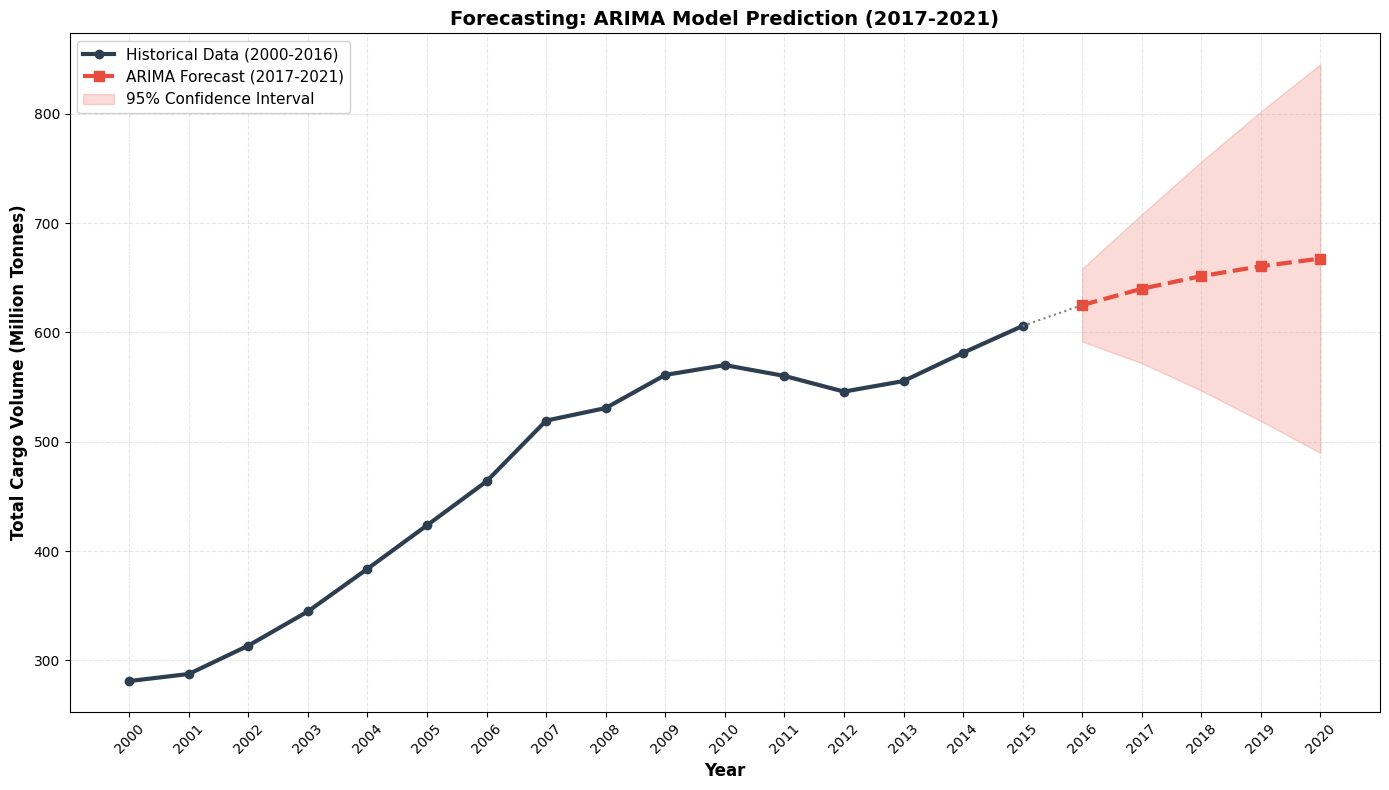


ARIMA Forecast:
2016: 625.01 MT (95% CI: 591.64 - 658.37)
2017: 639.88 MT (95% CI: 571.81 - 707.96)
2018: 651.46 MT (95% CI: 546.76 - 756.17)
2019: 660.48 MT (95% CI: 518.90 - 802.05)
2020: 667.49 MT (95% CI: 489.71 - 845.28)


In [19]:
# Fit ARIMA model
model = ARIMA(total_series, order=(1, 1, 0))
model_fit = model.fit()

# Forecast 5 years ahead
forecast_steps = 5
forecast = model_fit.forecast(steps=forecast_steps)
forecast_conf = model_fit.get_forecast(steps=forecast_steps)
forecast_ci = forecast_conf.conf_int()

# Create forecast years
forecast_years = np.arange(years.max() + 1, years.max() + 1 + forecast_steps)

# Plot
plt.figure(figsize=(14, 8))

# Historical data
plt.plot(years, total_series, color='#2c3e50', linewidth=3, 
         marker='o', markersize=6, label='Historical Data (2000-2016)')

# Forecast
plt.plot(forecast_years, forecast, color='#e74c3c', linewidth=3, 
         linestyle='--', marker='s', markersize=7, label='ARIMA Forecast (2017-2021)')

# Confidence interval
plt.fill_between(forecast_years, 
                 forecast_ci.iloc[:, 0], 
                 forecast_ci.iloc[:, 1], 
                 color='#e74c3c', alpha=0.2, 
                 label='95% Confidence Interval')

# Connect historical to forecast
plt.plot([years.iloc[-1], forecast_years[0]], 
         [total_series.iloc[-1], forecast.iloc[0]], 
         color='gray', linewidth=1.5, linestyle=':')

plt.xlabel('Year', fontsize=12, fontweight='bold')
plt.ylabel('Total Cargo Volume (Million Tonnes)', fontsize=12, fontweight='bold')
plt.title('Forecasting: ARIMA Model Prediction (2017-2021)', fontsize=14, fontweight='bold')
plt.legend(loc='upper left', fontsize=11, framealpha=0.9)
plt.grid(True, alpha=0.3, linestyle='--')

all_years = np.concatenate([years, forecast_years])
plt.xticks(all_years, rotation=45)
plt.tight_layout()
plt.show()

# Print forecast values
print("\nARIMA Forecast:")
for year, value, lower, upper in zip(forecast_years, forecast, 
                                      forecast_ci.iloc[:, 0], 
                                      forecast_ci.iloc[:, 1]):
    print(f"{year}: {value:.2f} MT (95% CI: {lower:.2f} - {upper:.2f})")

## 13. The Shift in a Snapshot (Slide 19)

Side-by-side pie charts comparing commodity composition in 2000 vs 2016.

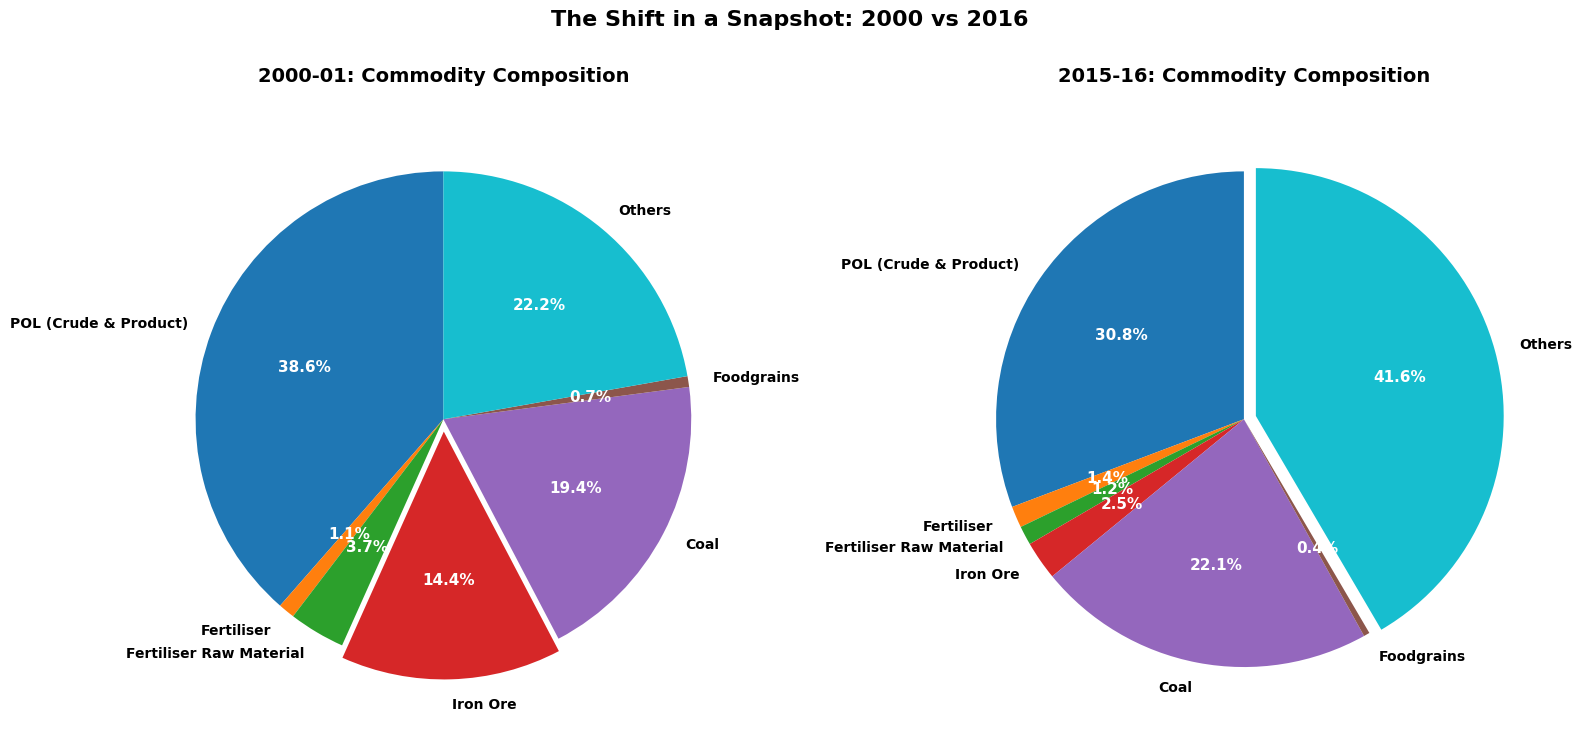


2000 vs 2016 Comparison:
----------------------------------------------------------------------
POL (Crude & Product)          | 2000:  38.6% | 2016:  30.8% | Change:  -7.8%
Fertiliser                     | 2000:   1.1% | 2016:   1.4% | Change:  +0.3%
Fertiliser Raw Material        | 2000:   3.7% | 2016:   1.2% | Change:  -2.4%
Iron Ore                       | 2000:  14.4% | 2016:   2.5% | Change: -11.9%
Coal                           | 2000:  19.4% | 2016:  22.1% | Change:  +2.7%
Foodgrains                     | 2000:   0.7% | 2016:   0.4% | Change:  -0.3%
Others                         | 2000:  22.2% | 2016:  41.6% | Change: +19.3%


In [20]:
# Get data for 2000 and 2016
data_2000 = df.iloc[0][commodities].values
data_2016 = df.iloc[-1][commodities].values

# Create consistent colors
colors = [commodity_colors[commodity] for commodity in commodities]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# 2000 Pie Chart
wedges1, texts1, autotexts1 = ax1.pie(data_2000, labels=commodities, autopct='%1.1f%%',
                                        colors=colors, startangle=90, 
                                        textprops={'fontsize': 10, 'fontweight': 'bold'},
                                        explode=[0.05 if c == 'Iron Ore' else 0 for c in commodities])
ax1.set_title('2000-01: Commodity Composition', fontsize=14, fontweight='bold', pad=20)

# Make percentage text white for better visibility
for autotext in autotexts1:
    autotext.set_color('white')
    autotext.set_fontsize(11)

# 2016 Pie Chart
wedges2, texts2, autotexts2 = ax2.pie(data_2016, labels=commodities, autopct='%1.1f%%',
                                        colors=colors, startangle=90, 
                                        textprops={'fontsize': 10, 'fontweight': 'bold'},
                                        explode=[0.05 if c == 'Others' else 0 for c in commodities])
ax2.set_title('2015-16: Commodity Composition', fontsize=14, fontweight='bold', pad=20)

# Make percentage text white for better visibility
for autotext in autotexts2:
    autotext.set_color('white')
    autotext.set_fontsize(11)

plt.suptitle('The Shift in a Snapshot: 2000 vs 2016', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print statistics
print("\n2000 vs 2016 Comparison:")
print("-" * 70)
for i, commodity in enumerate(commodities):
    pct_2000 = (data_2000[i] / data_2000.sum()) * 100
    pct_2016 = (data_2016[i] / data_2016.sum()) * 100
    change = pct_2016 - pct_2000
    print(f"{commodity:30s} | 2000: {pct_2000:5.1f}% | 2016: {pct_2016:5.1f}% | Change: {change:+5.1f}%")

---

## Summary

All 13 visualizations have been created with:

✅ **Consistent Color Scheme** - Each commodity has the same color across all plots
✅ **Clear Markdown Headings** - Each visualization is labeled for its corresponding slide
✅ **Professional Formatting** - Grid lines, legends, titles, and annotations
✅ **Statistical Insights** - Print statements showing key metrics

### Visualization Index:
1. **Slide 6** - Key Trends: All Commodities (Multi-line plot)
2. **Slide 7** - A Structural Shift in Trade (Stacked area chart)
3. **Slide 8** - How Do Commodities Relate? (Correlation heatmap)
4. **Slide 9** - Anchor: Port Traffic vs. GDP (Dual-axis chart)
5. **Slide 10** - The Main Story: An Annotated Timeline (Annotated multi-line)
6. **Slide 11** - Case Study 1: The 2004 Tsunami (Zoomed line plot)
7. **Slide 12** - Case Study 2: The 2008 Crisis (Zoomed line plot)
8. **Slide 13** - Case Study 3: The 2011 Iron Ore Collapse (Single commodity)
9. **Slide 14** - Case Study 4: The 'Engines of Growth' (POL & Coal)
10. **Slide 15** - Case Study 5: The 'Rise of Others' (Single commodity)
11. **Slide 17** - Deconstructing the Trend (HP Filter decomposition)
12. **Slide 18** - Forecasting: The ARIMA Model (Forecast with CI)
13. **Slide 19** - The Shift in a Snapshot (Side-by-side pie charts)

### Color Scheme Reference:
- POL (Crude & Product): Blue (#1f77b4)
- Fertiliser: Orange (#ff7f0e)
- Fertiliser Raw Material: Green (#2ca02c)
- **Iron Ore: Red (#d62728)** ← Highlighted in multi-line plots
- Coal: Purple (#9467bd)
- Foodgrains: Brown (#8c564b)
- **Others: Cyan (#17becf)** ← Highlighted in multi-line plots

**Note:** For Slide 9 (GDP comparison), you may need to update the `gdp_growth` list with actual India GDP growth data from World Bank or RBI.